Here we implement the whole process where U is applied multiple times. We use TrotterQRTE to provide Quantum Circuit and run the QC in simulator and collect the evolved state to proceed.

In [3]:
import sys
print(sys.executable)

C:\Users\schauue\Anaconda3\python.exe


In [4]:
import numpy as np
import scipy
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity, Operator
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit_aer import AerSimulator
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt
from scipy.linalg import expm, cosm
import warnings
import sys
import functools
import scipy as sc
from qiskit.visualization import plot_histogram

In [6]:
initial_state = Statevector.from_label('00000')
step = 10
time = 1
time_step = 20
nqubits = 4
periodic = True
J = 1/np.sqrt(2)
def get_hamiltonian_y(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZY', [nqubits, 1, 0], J)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()


def get_hamiltonian_i(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZI', [nqubits, 1, 0], J)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()

def get_hamiltonian(nqubits, J):
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()

In [6]:
## calculate exp based on un-scaled hamiltonian
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**4)) / (emax - emin) ## scale H

#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian = Operator(hamiltonian)
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
initial_state = Statevector.from_label("00000")
final_time = np.pi/2 #time
time_step = 10 #time_step
normalization_factor = SparsePauliOp.from_operator(Operator(np.kron(projector2, np.eye(2**nqubits))))

# Exact parts
exact_times = np.linspace(0, final_time, 101)
# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * np.kron(projector, H_array))) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian)/(sv.data.conj().dot(normalization_factor.to_matrix()).dot(sv.data)) for sv in exact_evolution])

##Trotter parts
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian, normalization_factor],)
trotter= TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)

print(exact_evolution[-1])
print(Statevector(result.evolved_state).data[:2**4])

Statevector([ 1.66883523e-01+0.j, -1.26455172e-01+0.j, -1.26455172e-01+0.j,
             -1.19416557e-02+0.j, -1.26455172e-01+0.j, -1.50275560e-02+0.j,
             -1.19416557e-02+0.j,  2.53688041e-03+0.j, -1.26455172e-01+0.j,
             -1.19416557e-02+0.j, -1.50275560e-02+0.j,  2.53688041e-03+0.j,
             -1.19416557e-02+0.j,  2.53688041e-03+0.j,  2.53688041e-03+0.j,
              2.73740019e-04+0.j,  9.42335810e-01+0.j,  6.58790795e-02+0.j,
              6.58790795e-02+0.j, -1.81134563e-02+0.j,  6.58790795e-02+0.j,
             -1.50275560e-02+0.j, -1.81134563e-02+0.j, -2.07101193e-03+0.j,
              6.58790795e-02+0.j, -1.81134563e-02+0.j, -1.50275560e-02+0.j,
             -2.07101193e-03+0.j, -1.81134563e-02+0.j, -2.07101193e-03+0.j,
             -2.07101193e-03+0.j,  4.14091845e-04+0.j],
            dims=(2, 2, 2, 2, 2))
[ 0.1668503 +3.06246575e-16j -0.12641993+1.17082431e-16j
 -0.12641993+5.46247541e-17j -0.01194745-4.69742754e-19j
 -0.12641993-6.05010675e-17j -0.0150

In [8]:
def count_gate(time, time_step):
    nqubits = 4
    result = []
    for i in [0, 1, 2, 4]:
        print(i)
        if i==0:
            circuit = QuantumCircuit(nqubits+1)
            hamiltonian = get_hamiltonian_y(nqubits+1, 1/np.sqrt(2), True)
            U = expm(-1.0j * time * hamiltonian.to_matrix())
            circuit.unitary(U, range(nqubits+1))
            circuit = circuit.decompose(reps=2)
            result.append(circuit.depth()) #depth, total gate, nonlocal gates
            result.append(len(circuit))
            result.append(circuit.num_nonlocal_gates())
        elif i==1:
            hamiltonian = get_hamiltonian_y(nqubits+1, 1/np.sqrt(2), True)
            trotter_step_first_order = PauliEvolutionGate(hamiltonian, time/time_step)
            circuit = QuantumCircuit(hamiltonian.num_qubits)
            for _ in range(time_step):
                circuit.append(trotter_step_first_order, range(hamiltonian.num_qubits))
            circuit = circuit.decompose(reps=2)
            result.append(circuit.depth()) #depth, total gate, nonlocal gates
            result.append(len(circuit))
            result.append(circuit.num_nonlocal_gates())
        else:
            hamiltonian = get_hamiltonian_y(nqubits+1, 1/np.sqrt(2), True)
            second_order_formula = SuzukiTrotter(i)  # if not passed, order defaults to 2
            trotter_step_second_order = PauliEvolutionGate(hamiltonian, time/time_step, synthesis=second_order_formula)
            circuit = QuantumCircuit(hamiltonian.num_qubits)
            for _ in range(time_step):
              circuit.append(trotter_step_second_order, range(hamiltonian.num_qubits))
            circuit = circuit.decompose(reps=2)
            result.append(circuit.depth()) #depth, total gate, nonlocal gates
            result.append(len(circuit))
            result.append(circuit.num_nonlocal_gates())
    return result

In [9]:
count_gate(10,2)

0
1
2
4


[945, 1273, 444, 112, 144, 48, 210, 270, 92, 1050, 1350, 460]

In [30]:
count_gate(10,3)

0
1
2
4


[945, 1273, 444, 168, 216, 72, 315, 405, 138, 1575, 2025, 690]

In [10]:
count_gate(10,10)

0
1
2
4


[945, 1273, 444, 560, 720, 240, 1050, 1350, 460, 5250, 6750, 2300]

In [7]:
nqubits = 4
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits, J)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 3 #time_step
initial_state = Statevector.from_label("0000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 1
step = 40
## 1st order
def construct_trotter_circuit(H, time, nqubits, order, time_step):
    if order == 1:
        formular = LieTrotter(reps=time_step)
    else:
        formular = SuzukiTrotter(order=order, reps=time_step)
    trotter_step_first_order = PauliEvolutionGate(H, time, synthesis=formular)
    circuit = QuantumCircuit(nqubits+1)
    circuit.append(trotter_step_first_order, range(nqubits+1))
    #circuit = circuit.decompose(reps=2)
    return circuit

def select_sim(error_rate):
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    if error_rate==0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
    return simulator

def unitary_trotter(H, time, nqubits, order, time_step, error_rate, step):
    simulator = select_sim(error_rate)
    expectation_list = []
    statevector = initial_state.data
    for i in range(step):
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        circuit_temp = construct_trotter_circuit(H, time, nqubits, order, time_step)
        qc = qc.compose(circuit_temp, range(nqubits+1))
        #qc = qc.decompose(reps=2)
        qc.save_statevector()
        circuit = transpile(qc, simulator)
        result = simulator.run(circuit).result().data(0)['statevector']
        new_state = result.data#[:2**nqubits]
        # Print the statevector at each step for debugging
        #print(f"Step {i}: Statevector = {statevector}")
        expectation = (new_state.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        expectation_list.append(expectation)
        # Print the expectation value at each step for debugging
        #print(f"Step {i}: Expectation = {expectation}")
        statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])
    return expectation_list

expectation_1 = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
print(expectation_1)





[(-0.06708079041848608-1.8957131776908529e-31j), (-0.7559843796453781+3.416208638822562e-31j), (-1.123353758612106-2.2497800339026958e-31j), (-1.367214093119157-1.1715084959759168e-30j), (-1.5766296580752137-2.6967810908791284e-31j), (-1.7796560014046963+2.0443733566576995e-30j), (-1.9784826803204363-1.495531052996703e-30j), (-2.167813104447966-5.573466125934315e-30j), (-2.3421544489624475+3.9024394701027326e-31j), (-2.49822668321896+4.575383850991272e-31j), (-2.635188555672128+1.227059502830168e-30j), (-2.7539840529518496-4.08352391828084e-30j), (-2.8565252586264345+3.481881190897066e-30j), (-2.94504451321487+3.3454918638579336e-30j), (-3.0216974504551266+4.2385848850203866e-30j), (-3.0883755918551588+5.984640553184702e-30j), (-3.1466542610474932+1.2071507759850639e-30j), (-3.197811618091543+3.992375800907206e-30j), (-3.242876167944916-1.8639314755646495e-29j), (-3.2826790911576635+5.4177815347647166e-30j), (-3.31790056288437-5.4544054452125746e-30j), (-3.349106575687106+3.27654704694

In [53]:
order = 2
expectation_2 = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
print(expectation_2)

[(-0.15549458140967556+2.5944581942898653e-33j), (-0.874199859446672-4.571565738374913e-31j), (-1.2919826948656326-5.7624435313320705e-31j), (-1.6006171544873806+1.1836677462213588e-30j), (-1.8836261433420494-1.7712609681062513e-30j), (-2.160715350436258-9.109051841434789e-31j), (-2.4253679248299305-2.7485909401198927e-30j), (-2.665808680256139-3.0491332910339432e-30j), (-2.8737299795711926-9.137189556762238e-30j), (-3.046427781029141+8.231075068521835e-31j), (-3.1857188703061503+1.0488338010336227e-29j), (-3.295924981066054+6.654271609644875e-30j), (-3.382165322976087-1.263763605925586e-29j), (-3.4493216329179877+1.1678137285931518e-29j), (-3.501577359497992-2.4270723085227195e-30j), (-3.5423114660455526-7.806501506496007e-30j), (-3.5741643593938095+5.7225299391378966e-30j), (-3.599164231992984-1.6600134269696637e-29j), (-3.6188580420140113-7.732395784855601e-30j), (-3.634424861733189-1.3003527354454814e-29j), (-3.6467661676992598-1.0081144656263783e-29j), (-3.6565747709089313-1.26793

In [54]:
order = 4
expectation_4 = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
print(expectation_4)

[(-0.15726323976811601+2.1280014912934477e-31j), (-0.8749593904605816+9.66175139715708e-31j), (-1.2924803134511935-2.4478963619196155e-30j), (-1.6011135057490344+6.584969573399928e-31j), (-1.8841479272429391-2.1953336664828224e-30j), (-2.1612101134236528+1.596196001032728e-31j), (-2.425792995735052-2.303483479235604e-30j), (-2.666148632724225-3.659227907403454e-30j), (-2.873987692976318-1.1734277603829761e-29j), (-3.046612487011038-1.0517320718061928e-29j), (-3.1858393402124774+0j), (-3.2959877904215262-7.281487538852479e-29j), (-3.3821755970052396-1.3143757859819577e-29j), (-3.4492842198031153-5.208593372703328e-29j), (-3.501497557906453-2.2636610050611096e-29j), (-3.542195204153916-2.57208288830378e-29j), (-3.5740180130934327+4.577539279843844e-29j), (-3.5989942940078805-2.5535190367256525e-29j), (-3.6186707871116677-5.4513411695477016e-30j), (-3.634226081344106+1.1092541014597401e-28j), (-3.646560996715537-4.1446115803512144e-29j), (-3.6563676012763837-5.071603611450809e-29j), (-3.6

In [55]:
len(expectation_4)

40

## Exact matrix exponential outside circuits

In [12]:
def num_exact(time, nqubits, error_rate, step):
    projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
    J = 1/np.sqrt(2)
    hamiltonian = get_hamiltonian(nqubits, J)
    H_array = hamiltonian.to_matrix()
    eval, _ = np.linalg.eigh(H_array)
# print(eval)
    emin = eval[0]
    emax = eval[-1]
    H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
    initial_state = Statevector.from_label("0"*nqubits)
    expectation_exact = []
    #simulator = select_sim(error_rate)
    statevector = initial_state.data
    density_matrix = np.outer(statevector, statevector.conj())
    for i in range(step):
        U = cosm(time * H_array)
        rho = U.dot(density_matrix).dot(U.T.conj())
        rho /= np.trace(rho)
        # qc = QuantumCircuit(nqubits+1)
        # qc.initialize(statevector, range(nqubits))
        # qc.unitary(U, range(nqubits+1))
        # qc.decompose(reps=2)
        # qc.save_statevector()
        # result = simulator.run(qc).result().data(0)['statevector']
        # new_state = result.data#[:2**nqubits]
        expectation = np.trace(rho.dot(hamiltonian.to_matrix()))#(new_state.conj().dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        expectation_exact.append(expectation)
        density_matrix = rho
        #statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])
    return expectation_exact

In [13]:
num_exact(np.pi/2, 4, 0, 40)

[(-0.1572607475401091+0j),
 (-0.8749572744784662+0j),
 (-1.292478454983243+0j),
 (-1.6011117167037436+0j),
 (-1.8841462228970873+0j),
 (-2.1612086115559217+0j),
 (-2.4257917971505307+0j),
 (-2.666147772451855+0j),
 (-2.873987143809993+0j),
 (-3.0466121863911653+0j),
 (-3.1858392172251655+0j),
 (-3.295987782528562+0j),
 (-3.3821756564172407+0j),
 (-3.4492843134085867+0j),
 (-3.5014976644674847+0j),
 (-3.5421953110014246+0j),
 (-3.574018113294421+0j),
 (-3.5989943842559833+0j),
 (-3.6186708662785936+0j),
 (-3.6342261495372314+0j),
 (-3.646561054689411+0j),
 (-3.65636765007834+0j),
 (-3.664180838669151+0j),
 (-3.6704165822200134+0j),
 (-3.675400203215073+0j),
 (-3.6793874298317917+0j),
 (-3.6825801580289426+0j),
 (-3.6851383596875618+0j),
 (-3.6871891609491163+0j),
 (-3.688833823801305+0j),
 (-3.6901531579638336+0j),
 (-3.6912117451947477+0j),
 (-3.692061256040254+0j),
 (-3.692743066671156+0j),
 (-3.69329033162946+0j),
 (-3.693729630759127+0j),
 (-3.694082281025608+0j),
 (-3.6943653834169

## With circuit

In [9]:
def unitary_exact(time, nqubits, error_rate, step):
    projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
    J = 1/np.sqrt(2)
    hamiltonian = get_hamiltonian(nqubits, J)
    H_array = hamiltonian.to_matrix()
    eval, _ = np.linalg.eigh(H_array)
# print(eval)
    emin = eval[0]
    emax = eval[-1]
    H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
    initial_state = Statevector.from_label("0"*nqubits)
    expectation_exact = []
    simulator = select_sim(error_rate)
    statevector = initial_state.data
    for i in range(step):
        U = expm(-1.0j * time * np.kron(projector, H_array))
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        qc.unitary(U, range(nqubits+1))
        qc.decompose(reps=2)
        qc.save_statevector()
        result = simulator.run(qc).result().data(0)['statevector']
        new_state = result.data#[:2**nqubits]
        expectation = (new_state.conj().dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        expectation_exact.append(expectation)
        statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])
    return expectation_exact

print(unitary_exact(np.pi/2, 4, 0, 40))

[(-0.15726074754010827+0j), (-0.8749572744784663+0j), (-1.292478454983243+0j), (-1.6011117167037447+0j), (-1.8841462228970893+0j), (-2.1612086115559235+0j), (-2.4257917971505325+0j), (-2.666147772451858+0j), (-2.873987143809996+0j), (-3.0466121863911666+0j), (-3.185839217225168+0j), (-3.2959877825285644+0j), (-3.3821756564172425+0j), (-3.4492843134085884+0j), (-3.5014976644674873+0j), (-3.542195311001426+0j), (-3.574018113294423+0j), (-3.5989943842559846+0j), (-3.6186708662785954+0j), (-3.6342261495372314+0j), (-3.6465610546894114+0j), (-3.6563676500783404+0j), (-3.6641808386691506+0j), (-3.6704165822200148+0j), (-3.6754002032150734+0j), (-3.6793874298317917+0j), (-3.6825801580289426+0j), (-3.6851383596875618+0j), (-3.6871891609491168+0j), (-3.6888338238013065+0j), (-3.690153157963834+0j), (-3.691211745194748+0j), (-3.6920612560402537+0j), (-3.6927430666711554+0j), (-3.693290331629461+0j), (-3.693729630759126+0j), (-3.6940822810256075+0j), (-3.694365383416987+0j), (-3.6945926596636816+

In [51]:
nqubits = 4
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
step = 40
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
initial_state = Statevector.from_label("0000")
expectation_exact = []
simulator = AerSimulator()
statevector = initial_state.data
for i in range(step):
    U = expm(-1.0j * time * np.kron(projector, H_array))
    qc = QuantumCircuit(nqubits+1)
    qc.initialize(statevector, range(nqubits))
    qc.unitary(U, range(nqubits+1))
    qc.decompose(reps=2)
    qc.save_statevector()
    result = simulator.run(qc).result().data(0)['statevector']
    new_state = result.data#[:2**nqubits]
    expectation = (new_state.conj().dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
    expectation_exact.append(expectation)
    statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])

    print(expectation)






(-0.15726074754010827+0j)
(-0.8749572744784663+0j)
(-1.292478454983243+0j)
(-1.6011117167037447+0j)
(-1.8841462228970893+0j)
(-2.1612086115559235+0j)
(-2.4257917971505325+0j)
(-2.666147772451858+0j)
(-2.873987143809996+0j)
(-3.0466121863911666+0j)
(-3.185839217225168+0j)
(-3.2959877825285644+0j)
(-3.3821756564172425+0j)
(-3.4492843134085884+0j)
(-3.5014976644674873+0j)
(-3.542195311001426+0j)
(-3.574018113294423+0j)
(-3.5989943842559846+0j)
(-3.6186708662785954+0j)
(-3.6342261495372314+0j)
(-3.6465610546894114+0j)
(-3.6563676500783404+0j)
(-3.6641808386691506+0j)
(-3.6704165822200148+0j)
(-3.6754002032150734+0j)
(-3.6793874298317917+0j)
(-3.6825801580289426+0j)
(-3.6851383596875618+0j)
(-3.6871891609491168+0j)
(-3.6888338238013065+0j)
(-3.690153157963834+0j)
(-3.691211745194748+0j)
(-3.6920612560402537+0j)
(-3.6927430666711554+0j)
(-3.693290331629461+0j)
(-3.693729630759126+0j)
(-3.6940822810256075+0j)
(-3.694365383416987+0j)
(-3.6945926596636816+0j)
(-3.6947751217325906+0j)


In [36]:
emin

-3.69551813004515

In [57]:
np.abs(expectation_exact[-1]-emin)/np.abs(emin)

0.0002010566005666951

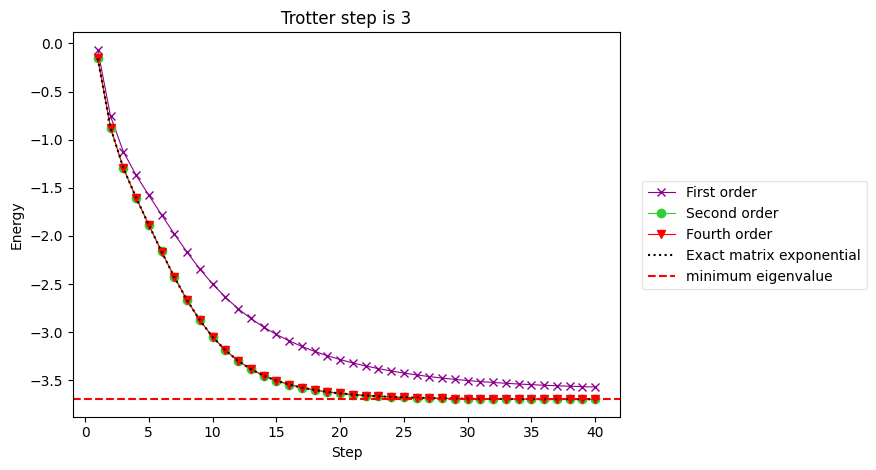

In [63]:
fig, axes = plt.subplots()
x = list(range(1, step+1))  # includes initial state
axes.plot(
    x, expectation_1, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    x, expectation_2, label="Second order", marker="o", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    x, expectation_4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8
)
axes.plot(x, expectation_exact, c="k", ls=":", label="Exact matrix exponential")
horizontal_line_value = emin
axes.axhline(y=horizontal_line_value, color='r', linestyle='--', label='minimum eigenvalue')#f'y = {horizontal_line_value}')
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)

axes.set_xticks(np.arange(0, max(x) + 1, 5))
axes.set_xlabel('Step')
axes.set_ylabel('Energy')
axes.set_title('Trotter step is 3')
fig.tight_layout()

8 qubits

Nqubits=6 and use trotter to construct circuit and see whether it speeds up than qc.unitary(U)

In [77]:
nqubits = 8
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
step = 20
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
initial_state = Statevector.from_label("00000000")
expectation_exact = []
simulator = AerSimulator()
statevector = initial_state.data
for i in range(step):
    U = expm(-1.0j * time * np.kron(projector, H_array))
    qc = QuantumCircuit(nqubits+1)
    qc.initialize(statevector, range(nqubits))
    qc.unitary(U, range(nqubits+1))
    qc.decompose(reps=2)
    qc.save_statevector()
    result = simulator.run(qc).result().data(0)['statevector']
    new_state = result.data#[:2**nqubits]
    expectation = (new_state.conj().dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
    expectation_exact.append(expectation)
    statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])

    print(expectation)

KeyboardInterrupt: 

In [14]:


nqubits = 8
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits, J)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
initial_state = Statevector.from_label("0000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = get_hamiltonian_y(nqubits+1, J, True)
#hamiltonian1 = Operator(hamiltonian1)
#hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 1
step = 20

circ = QuantumCircuit(nqubits+1)
U = expm(-1.0j * time * np.kron(projector, H_array))
circ.unitary(U, range(nqubits+1))
circ.save_statevector()
simulator.run(qc).result()

Result(backend_name='aer_simulator', backend_version='0.13.3', qobj_id='', job_id='6fb5afa0-4f54-4139-9780-cba495e8f0b6', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(statevector=Statevector([ 1.66883523e-01+0.j, -1.26455172e-01+0.j, -1.26455172e-01+0.j,
             -1.19416557e-02+0.j, -1.26455172e-01+0.j, -1.50275560e-02+0.j,
             -1.19416557e-02+0.j,  2.53688041e-03+0.j, -1.26455172e-01+0.j,
             -1.19416557e-02+0.j, -1.50275560e-02+0.j,  2.53688041e-03+0.j,
             -1.19416557e-02+0.j,  2.53688041e-03+0.j,  2.53688041e-03+0.j,
              2.73740019e-04+0.j,  9.42335810e-01+0.j,  6.58790795e-02+0.j,
              6.58790795e-02+0.j, -1.81134563e-02+0.j,  6.58790795e-02+0.j,
             -1.50275560e-02+0.j, -1.81134563e-02+0.j, -2.07101193e-03+0.j,
              6.58790795e-02+0.j, -1.81134563e-02+0.j, -1.50275560e-02+0.j,
             -2.07101193e-03+0.j, -1.81134563e-02+0.j, -2.07101193e-03+0.j,


In [2]:
"0"*4

'0000'

SparsePauliOp(['IZZY', 'ZZIY', 'ZIZY', 'IIXY', 'IXIY', 'XIIY'],
              coeffs=[0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j,
 0.70710678+0.j, 0.70710678+0.j])

In [15]:
def get_hamiltonian_y(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('YZZ', [nqubits, i, i+1], J) for i in range(0, nqubits-1)]
        X_tuples = [("YX", [nqubits, i], J) for i in range(0, nqubits)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('YZZ', [nqubits, i, i+1], J) for i in range(0, nqubits-1)]
        ZZ_tuples += [('YZZ', [nqubits, 0, nqubits-1], J)]
        X_tuples = [("YX", [nqubits, i], J) for i in range(0, nqubits)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()

get_hamiltonian_y(5, J,periodic=True)

nqubits = 4
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits, J)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 3 #time_step
initial_state = Statevector.from_label("0000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = get_hamiltonian_y(nqubits+1, J, True)
#hamiltonian1 = Operator(hamiltonian1)
#hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 1
step = 40
## 1st order
def construct_trotter_circuit(H, time, nqubits, order, time_step):
    if order == 1:
        formular = LieTrotter(reps=time_step)
    else:
        formular = SuzukiTrotter(order=order, reps=time_step)
    trotter_step_first_order = PauliEvolutionGate(H, time, synthesis=formular)
    circuit = QuantumCircuit(nqubits+1)
    circuit.append(trotter_step_first_order, range(nqubits+1))
    #circuit = circuit.decompose(reps=2)
    return circuit

def select_sim(error_rate):
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    if error_rate==0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
    return simulator

def unitary_trotter(H, time, nqubits, order, time_step, error_rate, step):
    simulator = select_sim(error_rate)
    expectation_list = []
    statevector = initial_state.data
    for i in range(step):
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        circuit_temp = construct_trotter_circuit(H, time, nqubits, order, time_step)
        qc = qc.compose(circuit_temp, range(nqubits+1))
        #qc = qc.decompose(reps=2)
        qc.save_statevector()
        circuit = transpile(qc, simulator)
        result = simulator.run(circuit).result().data(0)['statevector']
        new_state = result.data#[:2**nqubits]
        # Print the statevector at each step for debugging
        #print(f"Step {i}: Statevector = {statevector}")
        expectation = (new_state.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        expectation_list.append(expectation)
        # Print the expectation value at each step for debugging
        #print(f"Step {i}: Expectation = {expectation}")
        statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])
    return expectation_list

expectation_1 = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
print(expectation_1)



[(9.005404859831573e-15-1.4430475201454763e-15j), (1.4539650026662926e-16+5.522561042284922e-17j), (-6.826082564169909e-16+4.412845035598272e-17j), (-5.041989619490209e-16-8.009064361560561e-17j), (-1.3659113863509962e-15-3.7953819737446835e-17j), (-1.1342794641244755e-15+7.364493307713694e-45j), (-2.5276920295950606e-15-5.280870466907658e-17j), (-2.3168710507807344e-15+0j), (-2.0394778470853717e-15+4.9692765029036745e-17j), (-4.099512070213887e-16+1.9575461540708935e-44j), (-3.659557870011029e-15-4.7449761249593563e-17j), (-2.0256534675930724e-15+3.107851550273551e-17j), (-2.3277295373680273e-15+3.0626950847406875e-17j), (-7.621818712453491e-16+7.564674597316906e-17j), (-3.4955668209809397e-17+1.4978192490358968e-17j), (-1.2728831877999134e-15-2.227934496195914e-17j), (3.945586938674694e-16+2.2121843651172717e-17j), (-4.471060143095382e-16+4.397683457981116e-17j), (6.661399351374478e-16+7.291423654043902e-18j), (-2.5749349334301436e-15-2.1775800663316617e-17j), (-8.820087217798156e-16

In [16]:
temp_matrix1 = get_hamiltonian_y(5, J,periodic=True).to_matrix()


array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [17]:
hamiltonian1 = np.kron(projector2, get_hamiltonian(8, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)

In [18]:
def get_hamiltonian(nqubits):
    J = 1 / np.sqrt(2)
    ZZ_tuples = [('ZZ', [i, i + 1], J) for i in range(nqubits - 1)]
    ZZ_tuples += [('ZZ', [nqubits - 1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()


def main():
    H_array = get_hamiltonian(8).to_matrix()
    operator = Operator(np.kron(np.array([[0, -1.0j],
        [1.0j, 0]]),H_array))
    print('before sparsepauliop', flush=True)
    H = SparsePauliOp.from_operator(operator)
    print('sprse pauliop done', flush=True)

main()

before sparsepauliop
sprse pauliop done


In [22]:
import qiskit
print(qiskit.__version__)

1.0.0
